# 衛星データ解析手法別演習 ［分類編］
この章で学習すること
- この章では教師あり学習と教師なし学習の分類で用いるいくつかの解析手法を学びます。
- 衛星画像を使った土地被覆分類によく使われる解析手法を理解します。
- 解析手法を用いて土地被覆分類のプログラミングにトライします。

In [4]:
!pip install spectral
!pip install geopandas
!pip install rasterio
!pip install sentinelsat
!pip install cartopy
!pip install fiona
!pip install shapely
!pip install pyproj
!pip install pygeos
!pip install rtree
!pip install sat-search
!pip install pystac-client
!pip install rioxarray
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

以下の流れで説明します。
- scikit-learnを使った教師あり学習
  - サポートベクターマシーン（SVM）
  - 決定木
  - ロジスティック回帰
  - ニューラルネットワーク
  - ランダムフォレスト
  - ナイーブベイズ分類器
  - k近傍法
- scikit-learnを使った教師なし学習
  - K平均法
- その他の教師なし学習
  - 階層クラスタリング


In [5]:
#必要ライブラリのインポート
import os, sys
import numpy as np
import geopandas as gpd
import pandas as pd
import cartopy, pyproj, rtree, pygeos
import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['figure.dpi'] = 250 # 解像度

from osgeo import gdal, gdal_array
import folium
import zipfile
import glob
import shutil

from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona, shapely
from shapely.geometry import MultiPolygon, Polygon, box
from fiona.crs import from_epsg
import rasterio as rio
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.crs import CRS
import rioxarray as rxr
from osgeo import gdal
from rasterstats import zonal_stats
from rasterstats import point_query
from PIL import Image

import json
from pystac_client import Client
from satsearch import Search
from io import BytesIO
import urllib
import io
import requests
from IPython.display import IFrame

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Google Colabを使っている場合には、ドライブのマウントを行います
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 釧路市周辺を関心領域に設定する
from IPython.display import IFrame
src = 'https://www.keene.edu/campus/maps/tool/'
IFrame(src, width=960, height=500)

In [9]:
aoi = [
      [
       144.346615,
       43.0495725
       ],
      [
       144.3404354,
       42.9586839
       ],
      [
       144.5162118,
       42.9554174
       ],
      [
       144.5141519,
       43.0450563
       ],
      [
       144.346615,
       43.0495725
       ]
      ]

In [10]:
def selSquare(minLon, minLat, maxLon, maxLat):
   c1 = [maxLon, maxLat]
   c2 = [maxLon, minLat]
   c3 = [minLon, minLat]
   c4 = [minLon, maxLat]
   geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
   return geometry

In [11]:
# 関心領域の最小緯度・経度、最大緯度・経度を取得します
areaLon = []
areaLat = []
# iterating each number in list
for coordinate in aoi:
 areaLon.append(coordinate[0])
 areaLat.append(coordinate[1])

minLon = np.min(areaLon) # min longitude
maxLon = np.max(areaLon) # max longitude
minLat = np.min(areaLat) # min latitude
maxLat = np.max(areaLat) # max latitude

bbox = selSquare(minLon, minLat, maxLon, maxLat) # (min lon, min lat, max lon, max lat)
dates = '2020-01-01/2020-12-31'

api_url = 'https://earth-search.aws.element84.com/v0'
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A (BOA)
s2STAC = Client.open(api_url, headers=[])
s2STAC.add_conforms_to("ITEM_SEARCH")

s2Search = s2STAC.search (
   intersects = bbox,
   datetime = dates,
  #  query = {"eo:cloud_cover": {"lt": 10}, "sentinel:valid_cloud_cover": {"eq": True}},
   collections = collection)

s2_items = [i.to_dict() for i in s2Search.get_items()]
print(f"{len(s2_items)} のシーンを取得")

72 のシーンを取得


In [12]:
items = s2Search.get_all_items()
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
# 雲量で並び替え
gfSroted = gf.sort_values('eo:cloud_cover').reset_index(drop=True)
gfSroted.head()

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,data_coverage
0,"POLYGON ((144.75785 42.30246, 143.42731 42.338...",2020-02-14T01:25:11Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,T,YN,0,S2B_MSIL2A_20200214T011739_N0214_R031_T54TYN_2...,100,0.00,True,2020-09-19T01:28:31.852Z,2020-09-19T01:28:31.852Z,100.0
1,"POLYGON ((144.75785 42.30246, 143.42731 42.338...",2020-10-11T01:25:19Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,T,YN,0,S2B_MSIL2A_20201011T011659_N0214_R031_T54TYN_2...,100,0.00,False,2020-10-11T07:45:57.783Z,2020-10-11T07:45:57.783Z,NaN
2,"POLYGON ((144.75785 42.30246, 143.42731 42.338...",2020-10-16T01:25:21Z,sentinel-2a,sentinel-2,[msi],10,0,32654,54,T,YN,0,S2A_MSIL2A_20201016T011701_N0214_R031_T54TYN_2...,100,0.00,True,2020-10-16T08:53:23.865Z,2020-10-16T08:53:23.865Z,NaN
3,"POLYGON ((144.75785 42.30246, 143.42731 42.338...",2020-06-13T01:25:18Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,T,YN,0,S2B_MSIL2A_20200613T011659_N0214_R031_T54TYN_2...,100,0.05,True,2020-08-28T01:05:16.501Z,2020-08-28T01:05:16.501Z,100.0
4,"POLYGON ((144.75785 42.30246, 143.42731 42.338...",2020-12-10T01:25:13Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,T,YN,0,S2B_MSIL2A_20201210T012039_N0214_R031_T54TYN_2...,100,0.10,True,2020-12-10T06:43:43.983Z,2020-12-10T06:43:43.983Z,NaN


['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/54/T/YN/2020/6/13/0/preview.jpg']
[{'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/L2A_PVI.tif>, 'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/54/T/YN/2020/6/13/0/preview.jpg>, 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/54/T/YN/2020/6/13/0/metadata.xml>, 'B11': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B11.tif>, 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B01.tif>, 'B12': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B12.tif>, 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_

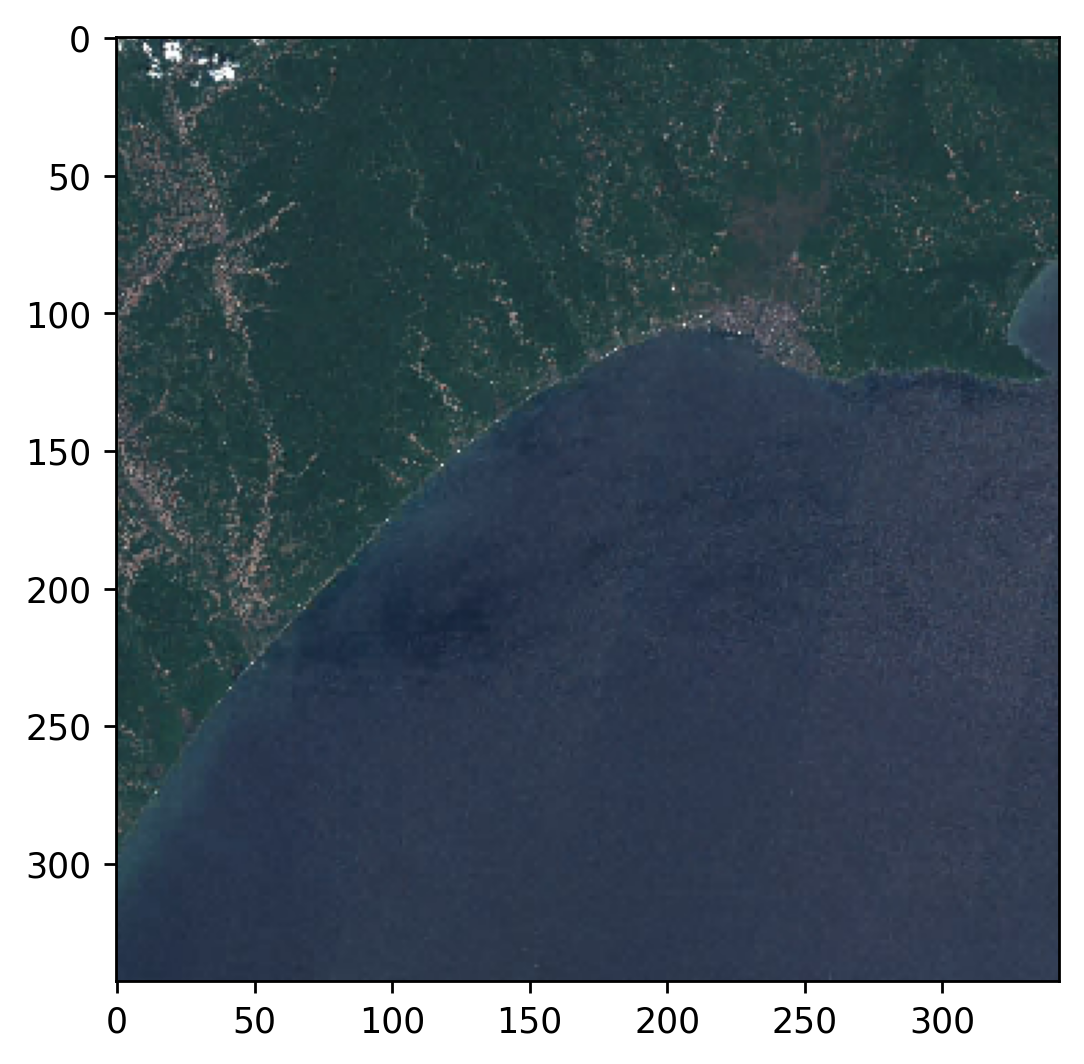

In [14]:
# 最も雲の量が少ないシーンを選択し、サムネイル画像も取得する関数を定義します。
def sel_items(scene_items, product_id):
 item = [x.assets for x in scene_items\
         if x.properties['sentinel:product_id'] == product_id]
 thumbUrl = [x.assets['thumbnail'].href for x in scene_items\
             if x.properties['sentinel:product_id'] == product_id]
 return item, thumbUrl

selected_item, thumbUrl = sel_items(items, gfSroted['sentinel:product_id'][3])
print(thumbUrl)
print(selected_item)

thumbImg = Image.open(BytesIO(requests.get(thumbUrl[0]).content))
plt.figure(figsize=(5,5))
plt.imshow(thumbImg)

In [15]:
# 引用：https://note.nkmk.me/python-download-web-images/
def download_file(url, dst_path):
   try:
       with urllib.request.urlopen(url) as web_file, open(dst_path, 'wb') as local_file:
           local_file.write(web_file.read())
   except urllib.error.URLError as e:
       print(e)

def download_file_to_dir(url, dst_dir):
   download_file(url, os.path.join(dst_dir, os.path.basename(url)))

In [16]:
# 取得するバンドの選択
bandLists = ['B02','B03','B04','B08'] # 4バンドを取得

# 画像のURL取得
file_url = []
[file_url.append(selected_item[0][band].href) for band in bandLists if file_url.append(selected_item[0][band].href) is not None]
file_url

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B02.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/YN/2020/6/S2B_54TYN_20200613_0_L2A/B08.tif']

In [17]:
base_path = os.path.dirname(os.path.abspath('__file__'))
file_path = os.path.join(base_path, "s2_classification")
if os.path.isdir(file_path) == False:
  os.makedirs(file_path)

In [18]:
# S2の画像をクリッピング。加えてCRSの変換も行う行う

def getFeatures(gdf):
   """rasterioで読み取れる形のデータに変換するための関数"""
   return [json.loads(gdf.to_json())['features'][0]['geometry']]

# 画像の読み込み
Rst_blue = rxr.open_rasterio(file_url[0],masked=True).squeeze() # B02
Rst_green = rxr.open_rasterio(file_url[1],masked=True).squeeze() # B03
Rst_red = rxr.open_rasterio(file_url[2],masked=True).squeeze() # B04
Rst_nir = rxr.open_rasterio(file_url[3],masked=True).squeeze() # B08
# print(Rst_red.rio.crs)

# rastrio crsオブジェクトの作成。UTM Zone54Nからwgs84へ変換
wgs4326 = CRS.from_string('EPSG:4326')

# 投影変換
Rst_blue_jgd = Rst_blue.rio.reproject(wgs4326)
Rst_green_jgd = Rst_green.rio.reproject(wgs4326)
Rst_red_jgd = Rst_red.rio.reproject(wgs4326)
Rst_nir_jgd = Rst_nir.rio.reproject(wgs4326)

# 画像の切り抜き処理
bbox = box(minLon, minLat, maxLon, maxLat)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
coords = getFeatures(geo)

# 画像の切り抜き処理
Rst_blue_clip = Rst_blue_jgd.rio.clip(coords)
Rst_green_clip = Rst_green_jgd.rio.clip(coords)
Rst_red_clip = Rst_red_jgd.rio.clip(coords)
Rst_nir_clip = Rst_nir_jgd.rio.clip(coords)

# GeoTIFFとして出力
# ローカル環境で実行する場合には実行ファイルと同じ階層に「s2_classification」というフォルダを作成してください
Rst_blue_clip.rio.to_raster(os.path.join(file_path,"blue.tif"))
Rst_green_clip.rio.to_raster(os.path.join(file_path,"green.tif"))
Rst_red_clip.rio.to_raster(os.path.join(file_path,"red.tif"))
Rst_nir_clip.rio.to_raster(os.path.join(file_path,"nir.tif"))

stratified_points.gpkgは事前にダウンロードをしてください。


ファイルは技術評論社のホームページからダウンロードいただけます。ダウンロードしたファイルは自分のGoogle Driveの任意の場所にアップロードしてください。

上のコードではテンポラリディレクトリの下に保存されていますので、そちらにパスを通しても問題ありません。

In [19]:
pointfile = '/content/stratified_points.gpkg' #任意のパス
s2folder = r'/content/s2_classification' #任意のパス

randomPoints = gpd.read_file(pointfile)

# 各点のピクセル値を読み取る
for root, folders, files in os.walk(s2folder):
    for file in files:
        f = os.path.join(root, file)
        if os.path.isfile(f) and f.endswith('.tif'):
          bandRaster = rxr.open_rasterio(f).sel(band=1)
          randomPoints_stats = pd.DataFrame(point_query
                                            (randomPoints,\
                                             bandRaster.values,\
                                             affine=bandRaster.rio.transform(),\
                                             nodata=bandRaster.rio.nodata))
          randomPoints_stats.columns=['{0}'.format(file.split('.')[0])]
          randomPoints = randomPoints.join(randomPoints_stats)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [21]:
randomPoints

,y,x,data,geometry,blue,red,nir,green
0,42.979958,144.355375,1,POINT (144.35538 42.97996),632.730340,557.190288,499.843418,695.016932
1,42.979542,144.349375,1,POINT (144.34938 42.97954),684.534894,578.506452,547.716768,742.020918
2,42.968458,144.352375,1,POINT (144.35237 42.96846),794.013633,582.360564,616.530028,764.121072
3,42.957625,144.367875,1,POINT (144.36787 42.95763),762.433714,577.791195,560.892574,794.198227
4,42.979292,144.354458,1,POINT (144.35446 42.97929),685.400162,589.528570,538.000673,739.632949
...,...,...,...,...,...,...,...,...
1995,42.984708,144.443708,4,POINT (144.44371 42.98471),363.050775,382.597314,4927.986872,775.558301
1996,43.008125,144.505208,4,POINT (144.50521 43.00812),444.806490,414.959844,5220.794725,780.653710
1997,43.047542,144.468958,4,POINT (144.46896 43.04754),385.014322,376.391676,4680.910395,833.217349
1998,42.996292,144.506792,4,POINT (144.50679 42.99629),303.026799,251.494441,4337.622118,605.618889


In [22]:
# Inf, NaNの除外除外処理
gdf = randomPoints[~randomPoints.isin([np.nan, np.inf, -np.inf]).any(1)]
msk = np.random.rand(len(gdf)) < 0.8
train = gdf[msk]
test = gdf[~msk]

In [23]:
from sklearn.svm import SVC

In [24]:
predictor_cols = ['blue', 'green', 'red', 'nir']
X = train[predictor_cols].values.tolist()
y = train['data'].tolist()

In [25]:
clf = SVC()
clf.fit(X, y)

# 検証
Xtest = test[predictor_cols]
ytest = test['data']
p = clf.predict(Xtest)
clf.score(Xtest,ytest) # Overall accuracy

0.8619854721549637

In [26]:
# 結果の描画
b2 = rio.open(os.path.join(s2folder, 'blue.tif')).read()
b2 = b2[0,:,:]
b3 = rio.open(os.path.join(s2folder, 'green.tif')).read()
b3 = b3[0,:,:]
b4 = rio.open(os.path.join(s2folder, 'red.tif')).read()
b4 = b4[0,:,:]
b8 = rio.open(os.path.join(s2folder, 'nir.tif')).read()
b8 = b8[0,:,:]
bands = np.dstack((b2,b3,b4,b8))
bands = bands.reshape(int(np.prod(bands.shape)/4),4)

r = clf.predict(bands) # 予測
r = r.reshape(b2.shape) # 2dアレイへreshape

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
  profile = b2src.profile
  profile.update(
      dtype=rio.uint8,
      count=1,
      compress='lzw')
  with rio.open('Classed_image_svm.tif', 'w', **profile) as dst:
    dst.write(r.astype(rio.uint8), 1)

In [27]:
from sklearn.tree import DecisionTreeClassifier
# モデルの訓練
DT = DecisionTreeClassifier()
DT.fit(X, y)

# 検証
p = DT.predict(Xtest)
DT.score(Xtest,ytest) # Overall accuracy

0.7772397094430993

In [28]:
r = DT.predict(bands)
r = r.reshape(b2.shape) 

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
  profile = b2src.profile
  profile.update(
      dtype=rio.uint8,
      count=1,
      compress='lzw')
  with rio.open('Classed_image_DT.tif', 'w', **profile) as dst:
    dst.write(r.astype(rio.uint8), 1)

In [29]:
from sklearn.linear_model import LogisticRegression
# モデルの訓練
LR = LogisticRegression(solver='lbfgs', multi_class='auto')
LR.fit(X, y)

# 検証
p = LR.predict(Xtest)
LR.score(Xtest,ytest) # Overall accuracy

0.864406779661017

In [30]:
r = LR.predict(bands)
r = r.reshape(b2.shape) 

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
  profile = b2src.profile
  profile.update(
      dtype=rio.uint8,
      count=1,
      compress='lzw')
  with rio.open('Classed_image_LR.tif', 'w', **profile) as dst:
    dst.write(r.astype(rio.uint8), 1)

In [31]:
from sklearn.neural_network import MLPClassifier
# モデルの訓練
NN = MLPClassifier(solver='lbfgs', random_state=42) 
NN.fit(X, y)

# 検証
p = NN.predict(Xtest)
NN.score(Xtest,ytest) # Overall accuracy

0.8571428571428571

In [32]:
r = NN.predict(bands)
r = r.reshape(b2.shape) 

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
  profile = b2src.profile
  profile.update(
      dtype=rio.uint8,
      count=1,
      compress='lzw')
  with rio.open('Classed_image_NN.tif', 'w', **profile) as dst:
    dst.write(r.astype(rio.uint8), 1)

In [33]:
from sklearn.ensemble import RandomForestClassifier
# モデルの訓練
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X, y)

# 検証
p = RF.predict(Xtest)
RF.score(Xtest,ytest) # Overall accuracy

0.8498789346246973

In [34]:
r = RF.predict(bands)
r = r.reshape(b2.shape)

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
 profile = b2src.profile
 profile.update(
     dtype=rio.uint8,
     count=1,
     compress='lzw')
 with rio.open('Classed_image_RF.tif', 'w', **profile) as dst:
   dst.write(r.astype(rio.uint8), 1)

In [35]:
from sklearn.naive_bayes import GaussianNB
# モデルの訓練
NB = GaussianNB()
NB.fit(X, y)

# 検証
p = NB.predict(Xtest)
NB.score(Xtest,ytest) # Overall accuracy

0.8208232445520581

In [36]:
r = NB.predict(bands)
r = r.reshape(b2.shape)

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
 profile = b2src.profile
 profile.update(
     dtype=rio.uint8,
     count=1,
     compress='lzw')
 with rio.open('Classed_image_NB.tif', 'w', **profile) as dst:
   dst.write(r.astype(rio.uint8), 1)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
# モデルの訓練
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X, y)

# 検証
p = KNN.predict(Xtest)
KNN.score(Xtest,ytest) # Overall accuracy

0.8595641646489104

In [38]:
r = KNN.predict(bands)
r = r.reshape(b2.shape)

# 結果の出力
b2src = rio.open(os.path.join(s2folder, 'blue.tif'))
with rio.Env():
 profile = b2src.profile
 profile.update(
     dtype=rio.uint8,
     count=1,
     compress='lzw')
 with rio.open('Classed_image_KNN.tif', 'w', **profile) as dst:
   dst.write(r.astype(rio.uint8), 1)